In [1]:
from collect_data import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
audio_path = os.path.join(meg_path, 'collect_data/audio')
megsp_list = os.listdir(megsp_path)
audio_list = os.listdir(audio_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

In [3]:
audio_tensor_train, audio_tensor_valid, audio_tensor_test = get_splitted_tensor(audio_list, audio_path)
audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)


DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 257, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 257, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 257, 376])
DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [4]:
x_train_mm = normalize_mm(audio_tensor_train) 
x_test_mm = normalize_mm(audio_tensor_test)
x_valid_mm = normalize_mm(audio_tensor_valid) 
x_train_ss = normalize_ss(audio_tensor_train)
x_test_ss = normalize_ss(audio_tensor_test) 
x_valid_ss = normalize_ss(audio_tensor_valid)  


In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        """
        """
        assert X.size(0) == Y.size(0), "The number of input and output samples must be the same"
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

BS=256

train_dataset = CustomDataset(x_train_mm.unsqueeze(1).float(), meg_tensor_train.float())
valid_dataset = CustomDataset(x_valid_mm.unsqueeze(1).float(), meg_tensor_valid.float())
test_dataset = CustomDataset(x_test_mm.unsqueeze(1).float(), meg_tensor_test.float())

# batch_size = 32  # --> da scegliere
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)



## Create A CNN Module

In [12]:

class CNNRegressor(pl.LightningModule):
    def __init__(self, channels, activation='relu', use_batchnorm=False, lr=0.001, weight_decay=0.0):
        super().__init__()
        self.save_hyperparameters()
        layers = []
        in_channels = 1  # Starting with 1 input channel

        self.train_losses = []
        self.val_losses = []
        self.train_tmp_losses = []
        self.val_tmp_losses = []
        # Select activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation.lower() == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function")

        for out_channels in channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(5,3), stride=2,padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(self.activation)
            in_channels = out_channels

        # Final Convolution to get to the desired output shape
        layers.append(nn.Conv2d(in_channels, 208, kernel_size=3, padding=1))
        # layers.append(nn.Upsample(size=(16, 26), mode='bilinear', align_corners=False))
        layers.append(nn.AdaptiveAvgPool2d((16, 26)))
        layers.append(nn.Conv2d(208, 208, kernel_size=3, padding=1))
        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.train_tmp_losses.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.val_tmp_losses.append(loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        return optimizer
    
    def on_train_epoch_end(self) -> None:
        self.train_losses.append(torch.stack(self.train_tmp_losses).mean())
        #reset tmp
        self.train_tmp_losses = []
        return super().on_train_epoch_end()
    def on_validation_epoch_end(self) -> None:
        self.val_losses.append(torch.stack(self.val_tmp_losses).mean())
        #reset tmp
        self.val_tmp_losses = []
        return super().on_validation_epoch_end()
    


# Model
channels = [64, 128, 256, 512]  # Example: 3 layers with increasing channels
model = CNNRegressor(channels)



In [13]:
#check shape
print(model(torch.randn(1,1,257,376)).shape)

summary(model, (1, 257, 376),device='cpu')

torch.Size([1, 208, 16, 26])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 188]           1,024
              ReLU-2         [-1, 64, 128, 188]               0
              ReLU-3         [-1, 64, 128, 188]               0
            Conv2d-4          [-1, 128, 63, 94]         123,008
              ReLU-5          [-1, 128, 63, 94]               0
              ReLU-6          [-1, 128, 63, 94]               0
            Conv2d-7          [-1, 256, 31, 47]         491,776
              ReLU-8          [-1, 256, 31, 47]               0
              ReLU-9          [-1, 256, 31, 47]               0
           Conv2d-10          [-1, 512, 15, 24]       1,966,592
             ReLU-11          [-1, 512, 15, 24]               0
             ReLU-12          [-1, 512, 15, 24]               0
           Conv2d-13          [-1, 208, 15, 24]         958,672
AdaptiveAv

In [18]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    # Get the index of the currently selected GPU (if any)
    current_gpu_index = torch.cuda.current_device()
    
    # Get the name of the currently selected GPU
    current_gpu_name = torch.cuda.get_device_name(current_gpu_index)
    
    print(f"GPU available: {gpu_available} (cuda), used: True")
    print(f"Currently selected GPU index: {current_gpu_index}")
    print(f"Currently selected GPU name: {current_gpu_name}")
else:
    print("GPU available: False")

GPU available: False


In [ ]:
EPOCHS=100 #obviously you should change this

# Trainer
trainer = pl.Trainer(max_epochs=EPOCHS, devices=[0])
trainer.fit(model, train_loader, valid_loader)

In [20]:
## Predict the train, validation and test set
model.eval()

with torch.no_grad():
#     train_preds = []
#     train_targets = []
#     for x, y in tqdm(train_loader):
#         train_preds.append(model(x).detach().cpu())
#         train_targets.append(y.detach().cpu())
#     train_preds = torch.cat(train_preds, dim=0)
#     train_targets = torch.cat(train_targets, dim=0)

    valid_preds = []
    valid_targets = []
    for x, y in tqdm(valid_loader):
        valid_preds.append(model(x).detach().cpu())
        valid_targets.append(y.detach().cpu())
    valid_preds = torch.cat(valid_preds, dim=0)
    valid_targets = torch.cat(valid_targets, dim=0)

    test_preds = []
    test_targets = []
    for x, y in tqdm(test_loader):
        test_preds.append(model(x).detach().cpu())
        test_targets.append(y.detach().cpu())

    test_preds = torch.cat(test_preds, dim=0)
    test_targets = torch.cat(test_targets, dim=0)

100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


In [22]:
# test_preds.shape

In [23]:


print("rmse", mean_squared_error(valid_targets.flatten(start_dim=1),valid_preds.flatten(start_dim=1)))
print("rmse", mean_squared_error(test_targets.flatten(start_dim=1),test_preds.flatten(start_dim=1)))

rmse 68.075806
rmse 74.88195


In [24]:
y_test_flat = test_targets.reshape(-1)
ridge_predictions_flat = test_preds.reshape(-1)
correlation_matrix = np.corrcoef(y_test_flat, ridge_predictions_flat)
print("Correlation matrix between actual and predicted:")
print(correlation_matrix)

Correlation matrix between actual and predicted:
[[1.         0.46310741]
 [0.46310741 1.        ]]


In [25]:
# pred_test_latent_reshape = torch.tensor(pred_test_latent).reshape(-1, 208, 16, 26)
sampling_meg

1000

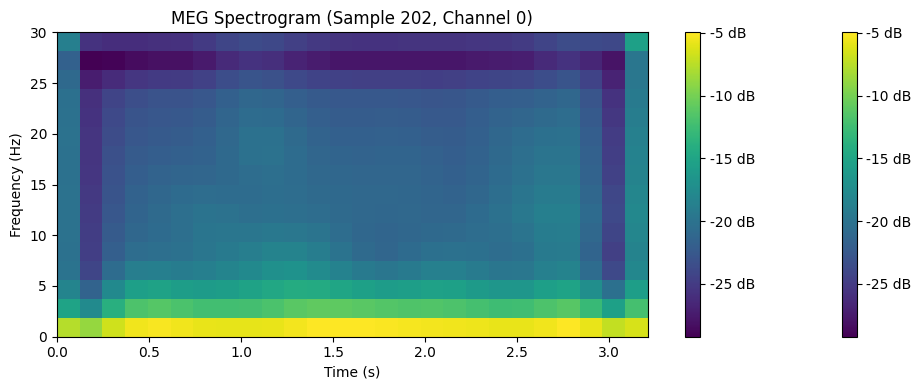

In [26]:
plot_spectrogram(test_preds, sampling_meg, 202, 0)

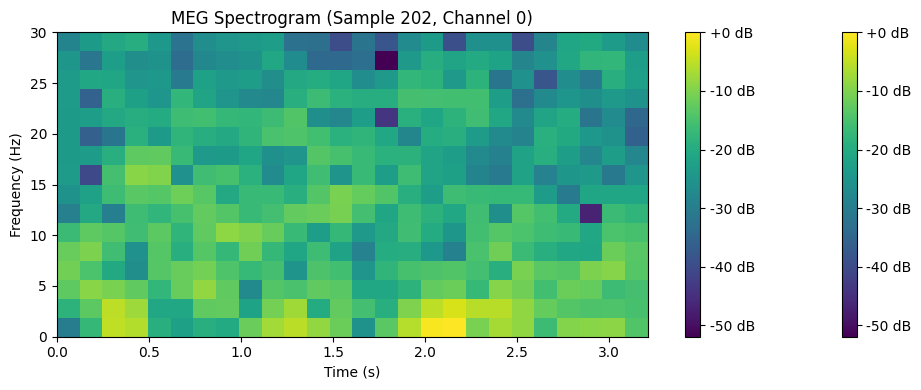

In [27]:
plot_spectrogram(test_targets, sampling_meg, 202, 0)

In [30]:
correlations = np.array([np.corrcoef(test_targets[:,i].flatten(start_dim=1), test_preds[:,i].flatten(start_dim=1))[0, 1] for i in range(num_channel)])


Extracting SQD Parameters from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteo/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


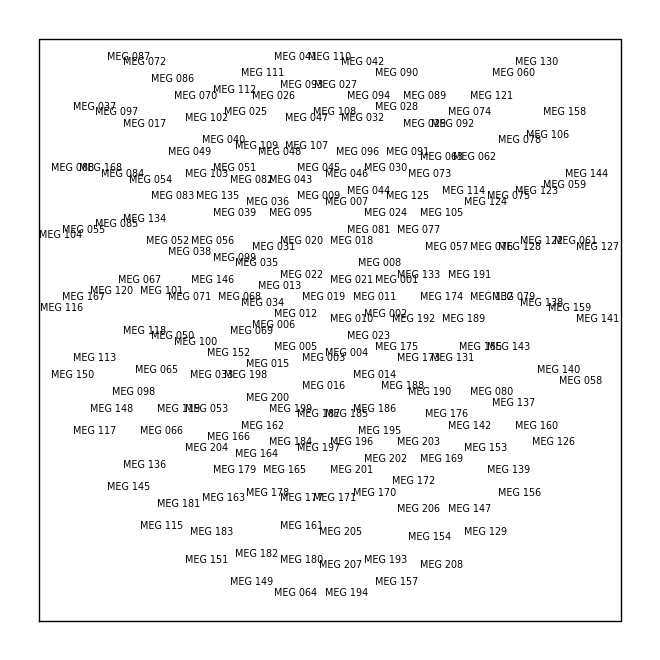

Figure(640x640)


In [28]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())


(208, 2)
(208,)


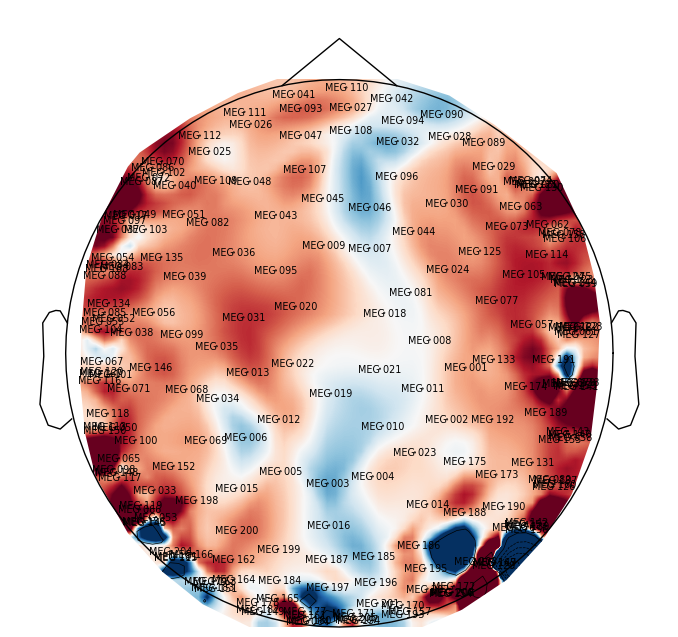

(<matplotlib.image.AxesImage at 0x7fb05d771250>,
 <matplotlib.contour.QuadContourSet at 0x7fb05d7714f0>)

In [9]:
meg_indices = mne.pick_types(raw.info, meg=True)
meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_indices])
print(meg_channel_positions.shape)

correlations = np.array(correlations).reshape(-1)
print(correlations.shape)
mne.viz.plot_topomap(correlations, meg_channel_positions, ch_type='meg', names=raw.info['ch_names'],
                     sphere=0.13, image_interp='cubic', extrapolate='local', border='mean', size=8.5, 
                     cmap='RdBu_r')